# Image Augmentation in IMGAUG library
Data augmentation is a strategy used to increase the amount of data by using techniques like cropping, padding, flipping, etc. Data augmentation makes the model more robust to slight variations, and hence prevents the model from overfitting. ImageDataGenerator generates batches of tensor image data with real-time data augmentation. The output images generated by the generator will have the same output dimensions as the input images.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from livelossplot import PlotLossesKeras
from livelossplot.keras import PlotLossesCallback
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(2020)

Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPool2D, Lambda
import keras
from livelossplot import PlotLossesKeras
from livelossplot.keras import PlotLossesCallback
from PIL import Image
import os
from os import listdir
from os.path import splitext
from imgaug import augmenters as iaa
from imgaug import parameters as iap

from keras.preprocessing.image import ImageDataGenerator
#!pip install livelossplot
#!pip install shapely
#!pip install imgaug

## Data preparation

In [3]:
# Loading of tensors X i y
X = np.load('X_vis_binary_class.npy')
y = np.load('y_vis_binary_class.npy')
print(X.shape, y.shape)

(7988, 128, 128, 3) (7988,)


In [22]:
# Split X i y to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2019)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# Conversion to float
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

(6390, 128, 128, 3) (6390,)
(1598, 128, 128, 3) (1598,)


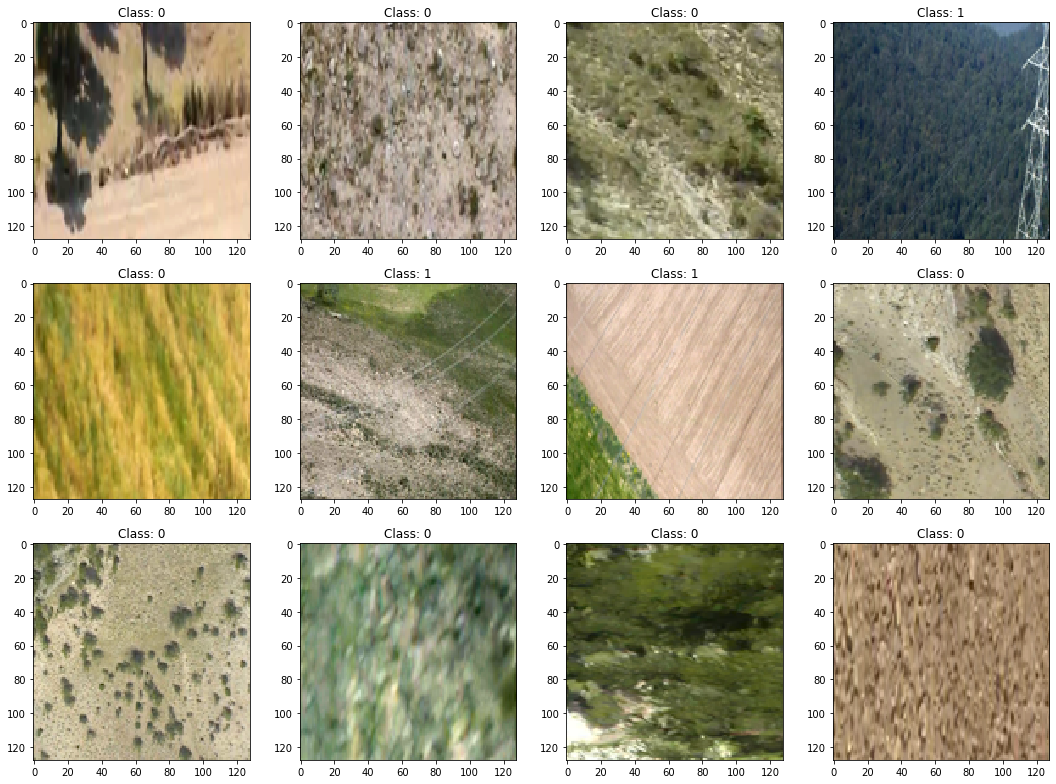

In [5]:
# Image visualization
plt.figure(figsize=(15,11))
for idx in range(12):
    plt.subplot(3,4,idx+1)
    img = X_train[idx]
    img = np.float32(np.interp(X_train[idx], (X_train[idx].min(), X_train[idx].max()), (0, 1)))
    plt.imshow(np.float32(img))
    plt.title('Class: {}'.format(y_train[idx]))# wyjściowa klasa 
plt.tight_layout()

# Augmentation using imgaug library

In [29]:
import imgaug as ia
import imgaug.augmenters as iaa
ia.seed(1)

In [ ]:
for i in range(12):
    plt.subplot(3,4,idx+1)
    img = X_train[idx]
    img = np.float32(np.interp(X_train[idx], (X_train[idx].min(), X_train[idx].max()), (0, 1)))

In [32]:
images = X_train.astype(np.uint8)
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    #iaa.ContrastNormalization((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order

images_aug = seq(images=images)

In [33]:
images_aug.shape

(6390, 128, 128, 3)

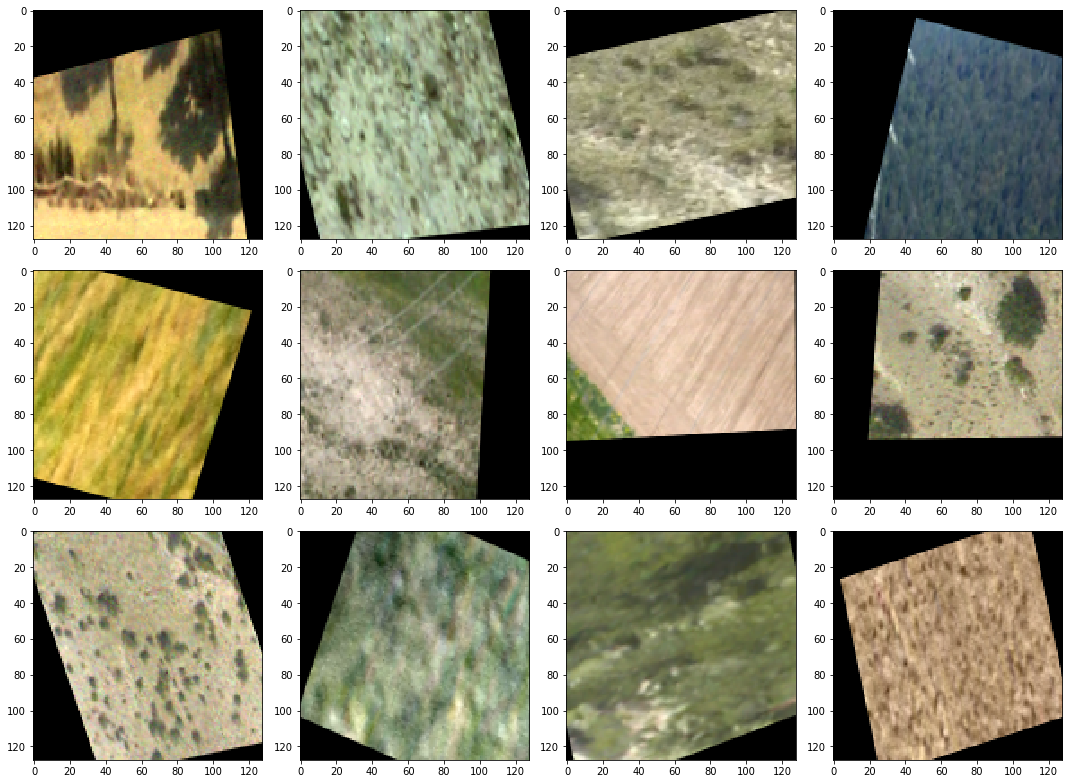

In [34]:
# Image visualization
plt.figure(figsize=(15,11))
for idx in range(12):
    plt.subplot(3,4,idx+1)
    img = images_aug[idx]
    img = np.float32(np.interp(images_aug[idx], (images_aug[idx].min(), images_aug[idx].max()), (0, 1)))
    plt.imshow(np.float32(img))
    #plt.title('Class: {}'.format(y_train[idx]))# wyjściowa klasa 
plt.tight_layout()

In [47]:
images = X_train.astype(np.uint8)

# Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image - it applies 
# Gaussian blur in 50% of all cases
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Sequence of augmentation steps that will be applied to every image.
seq = iaa.Sequential(
    [
        # Flip
        iaa.Fliplr(0.2), # horizontally flip 20% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images

        # Execute 0 to 5 of the following (less important) augmenters per
        # image. Don't execute all of them, as that would often be way too
        # strong.
        #
        iaa.SomeOf((0, 5),
            [
                # Convert some images into their superpixel representation,
                # sample between 20 and 200 superpixels per image, but do
                # not replace all superpixels with their average, only
                # some of them (p_replace).
                #sometimes(
                #    iaa.Superpixels(
                #        p_replace=(0, 1.0),
                #        n_segments=(20, 200)
                #    )
                #),

                # Blur each image with varying strength using gaussian blur (sigma between 0 and 2.0),
                # average/uniform blur (kernel size between 2x2 and 7x7) or median blur (kernel size between 
                # 3x3 and 7x7).
                iaa.OneOf([
                    iaa.GaussianBlur((0, 1.5)),
                    iaa.AverageBlur(k=(2, 5)),
                    iaa.MedianBlur(k=(3, 5)),
                ]),

                # Sharpen each image, overlay the result with the original
                # image using an alpha between 0 (no sharpening) and 1 (full sharpening effect).
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),

                # Same as sharpen, but for an embossing effect.
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),

                # Search in some images either for all edges or for
                # directed edges. These edges are then marked in a black
                # and white image and overlayed with the original image
                # using an alpha of 0 to 0.7.
                sometimes(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0, 0.7)),
                    #iaa.DirectedEdgeDetect(
                     #   alpha=(0, 0.3), direction=(0.0, 1.0)
                    #),
                ])),

                # Add gaussian noise to some images.
                # In 50% of these cases, the noise is randomly sampled per
                # channel and pixel.
                # In the other 50% of all cases it is sampled once per
                # pixel (i.e. brightness change).
                #iaa.AdditiveGaussianNoise(
                 #   loc=0, scale=(0.0, 0.05*255), per_channel=0.5
                #),

                # Either drop randomly 1 to 10% of all pixels (i.e. set
                # them to black) or drop them on an image with 2-5% percent
                # of the original size, leading to large dropped
                # rectangles.
                #iaa.OneOf([
                 #   iaa.Dropout((0.01, 0.1), per_channel=0.5),
                  #  iaa.CoarseDropout(
                   #     (0.03, 0.15), size_percent=(0.02, 0.05),
                    #    per_channel=0.2
                    #),
                #]),

                # Invert each image's channel with 5% probability.
                # This sets each pixel value v to 255-v.
                #iaa.Invert(0.05, per_channel=True), # invert color channels

                # Add a value of -10 to 10 to each pixel.
                iaa.Add((-10, 10), per_channel=0.5),

                # Change brightness of images (50-150% of original value).
                iaa.Multiply((0.8, 1.2), per_channel=0.5),

                # Improve or worsen the contrast of images.
                iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5),

                # Convert each image to grayscale and then overlay the
                # result with the original with random alpha. I.e. remove
                # colors with varying strengths.
                #iaa.Grayscale(alpha=(0.0, 1.0)),

                # In some images move pixels locally around (with random
                # strengths).
                sometimes(
                    iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)
                ),

                # In some images distort local areas with varying strength.
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05)))
            ],
            # do all of the above augmentations in random order
            random_order=True
        )
    ],
    # do all of the above augmentations in random order
    random_order=True
)

images_aug = seq(images=images)
images_aug.shape

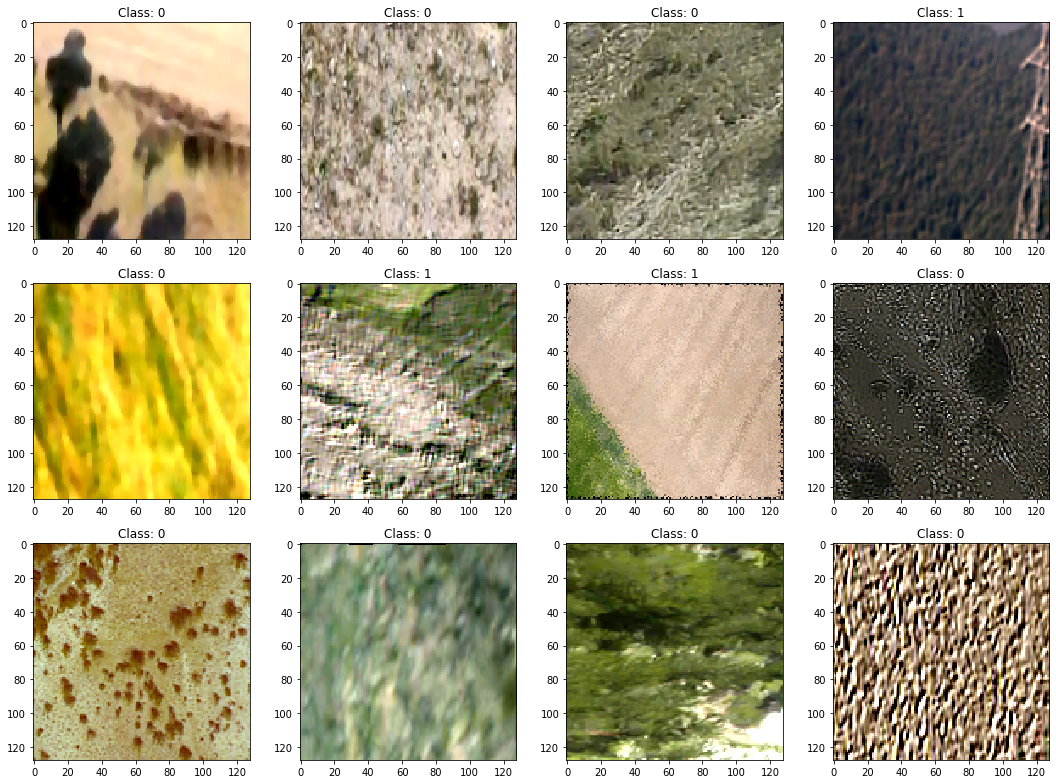

In [50]:
# Image visualization
plt.figure(figsize=(15,11))
for idx in range(12):
    plt.subplot(3,4,idx+1)
    img = images_aug[idx]
    img = np.float32(np.interp(images_aug[idx], (images_aug[idx].min(), images_aug[idx].max()), (0, 1)))
    plt.imshow(np.float32(img))
    plt.title('Class: {}'.format(y_train[idx]))# wyjściowa klasa 
plt.tight_layout()

In [51]:
Xgen = images_aug
ygen = y_train
print(Xgen.shape, ygen.shape)

(6390, 128, 128, 3) (6390,)


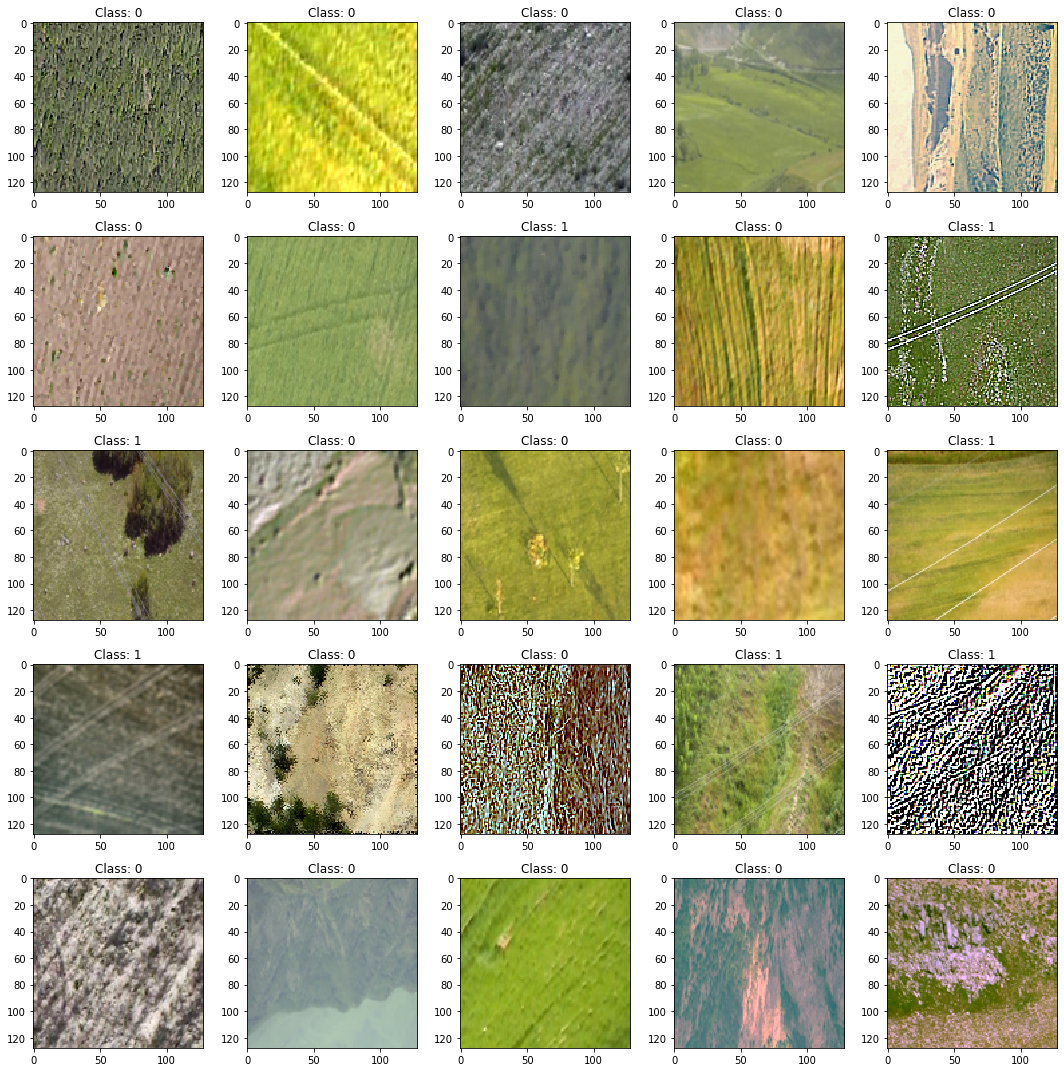

In [53]:
# Visualization of 25 random images from Xgen  
nr_img = np.random.randint(Xgen.shape[0], size=(1, 25))

plt.figure(figsize=(15,15))
for idx in range(25):
    plt.subplot(5,5,idx+1)
    img = Xgen[nr_img[0][idx]]
    plt.imshow(img)
    plt.title('Class: {}'.format(ygen[nr_img[0][idx]]))# wyjściowa klasa 
    
plt.tight_layout()